In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
train = pd.read_csv('prep_train.csv')
val = pd.read_csv('prep_val.csv')

In [33]:
test = pd.read_csv('prep_test.csv')

In [51]:
train.shape, val.shape, test.shape

((129066, 39), (21511, 139), (64533, 57))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
train['text'] = train['text'].apply(lambda x: x[:512])
train['class'] = train['class'].map({'M': 1, 'H': 0})

In [6]:
val['text'] = val['text'].apply(lambda x: x[:512])
val['class'] = val['class'].map({'M': 1, 'H': 0})

In [36]:
test['text'] = test['text'].apply(lambda x: x[:512])

In [7]:
train['text'] = train['text'].apply(lambda x: '[CLS] ' + x + ' [SEP]')

In [8]:
val['text'] = val['text'].apply(lambda x: '[CLS] ' + x + ' [SEP]')

In [37]:
test['text'] = test['text'].apply(lambda x: '[CLS] ' + x + ' [SEP]')

In [9]:
cols = [col for col in list(train) if 'ft_' not in col]

dropped_cols = ['count_POS_text', 'POS_text', 'id', 'class', 'lemm_text']

for col in dropped_cols:
    cols.pop(cols.index(col))

In [10]:
train.fillna(0, inplace=True)
val.fillna(0, inplace=True)

In [39]:
test.fillna(0, inplace=True)

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler()

In [13]:
x_train, y_train = train[cols], train['class']
x_val, y_val = val[cols], val['class']

In [40]:
x_test = test[cols]

In [14]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [15]:
from tqdm import tqdm

tokenized_texts = [tokenizer.tokenize(sent) for sent in tqdm(x_train['text'])]

100%|█████████████████████████████████████████████████████████████████████████| 129066/129066 [00:58<00:00, 2204.83it/s]


In [16]:
val_tokenized_texts = [tokenizer.tokenize(sent) for sent in tqdm(x_val['text'])]

100%|███████████████████████████████████████████████████████████████████████████| 21511/21511 [00:09<00:00, 2198.38it/s]


In [41]:
test_tokenized_texts = [tokenizer.tokenize(sent) for sent in tqdm(x_test['text'])]

100%|███████████████████████████████████████████████████████████████████████████| 64533/64533 [00:29<00:00, 2160.09it/s]


In [17]:
feature_cols = [col for col in list(x_train)]
feature_cols = feature_cols[1:][:14] + feature_cols[1:][15:]

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_inputs = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_texts)]

train_inputs = pad_sequences(train_inputs, 
                          dtype='long', 
                          padding='post', 
                          truncating='post')

train_masks = [[float(i>0) for i in seq] for seq in train_inputs]

validation_inputs = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(val_tokenized_texts)]

validation_inputs = pad_sequences(validation_inputs, 
                          dtype='long', 
                          padding='post', 
                          truncating='post')


validation_masks = [[float(i>0) for i in seq] for seq in validation_inputs]

train_labels, validation_labels = np.array(y_train), np.array(y_val)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

train_features = np.array(train[feature_cols], dtype='float32')
validation_features = np.array(val[feature_cols], dtype='float32')
train_features = scaler.fit_transform(train_features)
validation_features = scaler.transform(validation_features)

train_features = torch.tensor(train_features)
validation_features = torch.tensor(validation_features)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_data = torch.utils.data.TensorDataset(train_inputs, train_masks, train_features, train_labels)
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=8,
    sampler=torch.utils.data.RandomSampler(train_data)
)

validation_data = torch.utils.data.TensorDataset(validation_inputs, validation_masks, validation_features, validation_labels)
validation_dataloader = torch.utils.data.DataLoader(
    validation_data,
    batch_size=8,
    sampler=torch.utils.data.SequentialSampler(validation_data)
)

100%|██████████████████████████████████████████████████████████████████████████| 21511/21511 [00:00<00:00, 34690.41it/s]


In [42]:
test_inputs = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(test_tokenized_texts)]

test_inputs = pad_sequences(test_inputs, 
                          dtype='long', 
                          padding='post', 
                          truncating='post')


test_masks = [[float(i>0) for i in seq] for seq in test_inputs]

test_inputs = torch.tensor(test_inputs)
test_masks = torch.tensor(test_masks)

test_features = np.array(test[feature_cols], dtype='float32')
test_features = scaler.transform(test_features)
test_features = torch.tensor(test_features)

test_data = torch.utils.data.TensorDataset(test_inputs, test_masks, test_features)
test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=8,
    sampler=torch.utils.data.SequentialSampler(test_data)
)

100%|██████████████████████████████████████████████████████████████████████████| 64533/64533 [00:01<00:00, 33404.96it/s]


In [19]:
from transformers import AdamW, BertConfig

In [20]:

class myBertModel(torch.nn.Module):
    def __init__(self, hidden_neurons, n_features):
        super(myBertModel, self).__init__()
        config = BertConfig.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=2)
        self.model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased', config=config)
        self.hidden_neurons = hidden_neurons
        self.n_features = n_features
        self.linear_1 = torch.nn.Linear(config.hidden_size, self.hidden_neurons)
        self.linear_2 = torch.nn.Linear(self.hidden_neurons, int(self.hidden_neurons / 2))
        self.linear_3 = torch.nn.Linear(self.n_features, int(self.n_features / 2))
        self.linear_4 = torch.nn.Linear(int(self.n_features / 2), int(self.hidden_neurons / 2))
        self.classifier = torch.nn.Linear(self.hidden_neurons, 2)
        self.activation = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(.1)

    def forward(self, input_ids, attention_mask, features):
        bert_output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        seq_output = bert_output[0]
        pooled_output = seq_output.mean(axis=1)
        pooled_output = self.dropout(pooled_output)
        linear_output = self.linear_1(pooled_output)
        linear_output_2 = self.linear_2(linear_output)
        linear_output_3 = self.linear_3(features)
        linear_output_3 = self.dropout(linear_output_3)
        linear_output_4 = self.linear_4(linear_output_3)
        scores = self.classifier(torch.cat([linear_output_2, linear_output_4], dim=1))
        scores = self.dropout(scores)
        scores = self.activation(scores)
        return scores

my_model = myBertModel(hidden_neurons=512, n_features=len(feature_cols))
# my_model = myBertModel(hidden_neurons=512)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
optimizer = AdamW(my_model.parameters(), lr=1e-5)
loss = torch.nn.CrossEntropyLoss()

In [22]:
my_model.to(device)
my_model.train()

myBertModel(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [23]:
from tqdm import tqdm

In [24]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

In [25]:
loss_set = []
val_loss_set = []

n_epochs = 3

for epoch in range(n_epochs):
    
    train_labels = []
    train_preds = []
    
    my_model.train()
    
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_features, b_labels = batch
        optimizer.zero_grad()
        pred_probs = my_model.forward(b_input_ids, b_input_mask, b_features)
        my_loss = loss(pred_probs, b_labels)
        loss_set.append(my_loss.item())
        my_loss.backward()
        optimizer.step()
        
        b_labels = b_labels.to('cpu').numpy()
        pred_probs = pred_probs.detach().to('cpu').numpy()
        pred_labels = pred_probs.argmax(axis=1)
        
        train_labels.extend(b_labels)
        train_preds.extend(pred_labels)
        
    train_acc = accuracy_score(train_labels, train_preds)
    train_precision = precision_score(train_labels, train_preds)
    train_recall = recall_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds)   
    
    print('Epoch {} ... Train accuracy: {:.2f} ... Train precision: {:.2f} ... Train recall: {:.2f} ... Train f1: {:.2f} ... Train loss: {:.4f}'.format(epoch, train_acc, train_precision, train_recall, train_f1, my_loss.item()))
        
    val_labels = []
    val_preds = []
    
    my_model.eval()
    
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_features, b_labels = batch

        with torch.no_grad():
            pred_probs = my_model.forward(b_input_ids, b_input_mask, b_features)
            val_loss = loss(pred_probs, b_labels)
            val_loss_set.append(val_loss.item())

        b_labels = b_labels.to('cpu').numpy()
        pred_probs = pred_probs.detach().to('cpu').numpy()

        pred_labels = pred_probs.argmax(axis=1)

        val_labels.extend(b_labels)
        val_preds.extend(pred_labels)

    val_acc = accuracy_score(val_labels, val_preds)
    val_precision = precision_score(val_labels, val_preds)
    val_recall = recall_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)

    print('Epoch {} ... Val accuracy: {:.2f} ... Val precision: {:.2f} ... Val recall: {:.2f} ... Val f1: {:.2f} ... Val loss: {:.4f}'.format(epoch, val_acc, val_precision, val_recall, val_f1, val_loss.item()))
    print()
    print('-------------------------------------------------------------------------------------------------------------------------')
    print()

Epoch 0 ... Train accuracy: 0.75 ... Train precision: 0.76 ... Train recall: 0.75 ... Train f1: 0.75 ... Train loss: 0.4401
Epoch 0 ... Val accuracy: 0.79 ... Val precision: 0.82 ... Val recall: 0.75 ... Val f1: 0.78 ... Val loss: 0.4721

-------------------------------------------------------------------------------------------------------------------------

Epoch 1 ... Train accuracy: 0.83 ... Train precision: 0.84 ... Train recall: 0.82 ... Train f1: 0.83 ... Train loss: 0.3135
Epoch 1 ... Val accuracy: 0.80 ... Val precision: 0.81 ... Val recall: 0.78 ... Val f1: 0.80 ... Val loss: 0.4482

-------------------------------------------------------------------------------------------------------------------------

Epoch 2 ... Train accuracy: 0.87 ... Train precision: 0.88 ... Train recall: 0.86 ... Train f1: 0.87 ... Train loss: 0.3133
Epoch 2 ... Val accuracy: 0.80 ... Val precision: 0.79 ... Val recall: 0.81 ... Val f1: 0.80 ... Val loss: 0.4046

-------------------------------------

In [29]:
torch.save(my_model.state_dict(), 'bert_model.pt')

In [44]:
test_preds = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_features = batch
    with torch.no_grad():
        pred_probs = my_model.forward(b_input_ids, b_input_mask, b_features)
        pred_labels = pred_probs.detach().to('cpu').numpy().argmax(axis=1)
        test_preds.extend(pred_labels)

In [47]:
submission_data = pd.read_csv('test.csv')
submission_data['Class'] = test_preds
submission_data['Class'] = submission_data['Class'].map({0: 'H', 1: 'M'})
submission_data[['Id', 'Class']].to_csv('submission.csv', index=False)

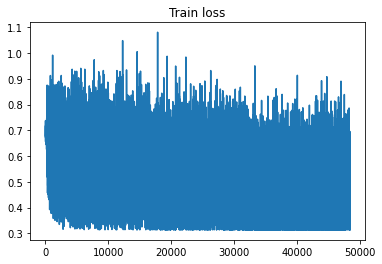

In [26]:
plt.plot(loss_set)
plt.title('Train loss')
plt.show()

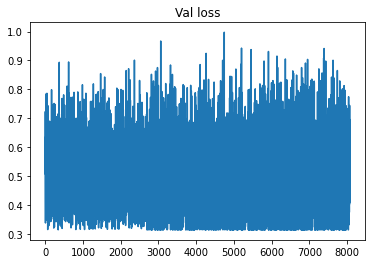

In [27]:
plt.plot(val_loss_set)
plt.title('Val loss')
plt.show()